In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingRegressor

IV. 4차 프로그래밍과제 구현 내용

(1) II. 데이터 셋에서 주어진 특징들을 선택하여 CPU 성능 즉, “PRP” 변수를 예측하는 Pipeline 기반 다중 회귀 모델링을 프로그래밍 하시오.
- 데이터 탐색 및 시각화, 전처리, 훈련 데이터와 테스트 데이터 분리, 하이퍼파라미터 튜닝, 훈련 데이터 앙상블 학습 과정, 교차 검증, 분석 결과 시각화 등을 포함하여 최적화하는 전체 과정을 포함하시오.

(2) (1) 단계에서 얻은 Pipeline 기반 모델 GridSearchCV의 best_estimator모델을 사용하여 학습 데이터와 테스트 데이터 각각에 대해 이 모델의 성능을 평가하시오.
- Mean squared Error, Mean absolute Error, R^2, 교차검증

(3) (2) 단계에서 얻은 Pipeline 기반 GridSearchCV의 best_estimator모델의 테스트 데이터에 대해 예측 성능 R^2가 85% 이상이 나오도록 모델을 개선하시오.

(4) I. 3차 프로그래밍 과제의 기본모델의 (2) 단계와 II. 4차 프로그래밍 과제의 제안 모델의 (2) 단계에서 얻은 학습 데이터와 테스트 데이터에 대한 성능 지표(MSE, MAE, R^2, 교차 검증)를 데이터프레임에 저장하여 이 성능 결과를 바 차트로 시각화하여 학습 데이터와 테스트 데이터에 대한 각 모델의 성능 차이를 비교 분석하시오.
예시)




(5) (1), (2), (3), (4) 단계 전 과정을 포함한 전체 프로그래밍을 소스파일 “pipeline_cpu_data.ipynb”로 작성해서 사이버캠퍼스 “4차 프로그래밍과제”와 github에 각각 업로드 하시오.

(1) II. 데이터 셋에서 주어진 특징들을 선택하여 CPU 성능 즉, “PRP” 변수를 예측하는 Pipeline 기반 다중 회귀 모델링을 프로그래밍 하시오.
- 데이터 탐색 및 시각화, 전처리, 훈련 데이터와 테스트 데이터 분리, 하이퍼파라미터 튜닝, 훈련 데이터 앙상블 학습 과정, 교차 검증, 분석 결과 시각화 등을 포함하여 최적화하는 전체 과정을 포함하시오.

Text(0.5, 1.0, 'PRP')

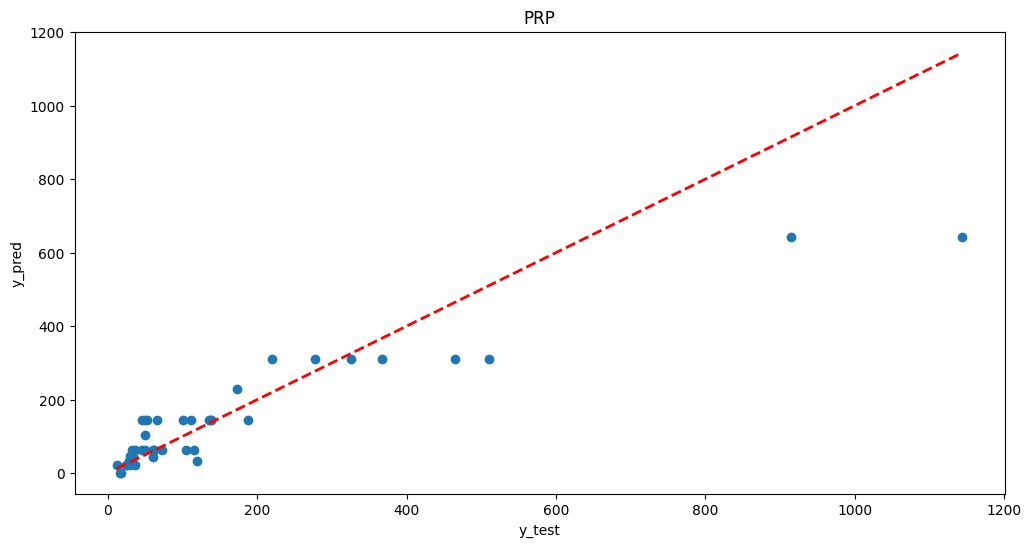

In [60]:
cpu = pd.read_csv("machine.data_update.csv")

# 상관도를 계산하기 특징들을 모두 수치화 변환
# 범주형 데이터 수치화
dum = pd.get_dummies(cpu['VendorName'], prefix='c', dtype=float)
cpu = pd.concat([cpu.drop('VendorName', axis=1), dum], axis =1)
cpu.head()

dum = pd.get_dummies(cpu['ModelName'], prefix='c', dtype=float)
cpu = pd.concat([cpu.drop('ModelName', axis=1), dum], axis =1)
cpu.head()

# (1) PRP에 관련된 다른 특성들과의 상관계수 값만을 출력
result = cpu.corr()['PRP']
# 상관계수 값을 양의 상관계수로 처리
result = np.abs(result)
# 상관계수를 내림차순으로 정렬하기
result.sort_values(ascending = False)

# 맴버 features 선택
num_features = ['MMAX']

X = cpu[num_features] # 2차원 배열
y = cpu['PRP'] # 1차원 시리즈

#데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state= 21)

# 전처리 파이프라인 설정
num_tranformer = Pipeline(steps=[
    ('scaler',StandardScaler()),
])

preprocessor = ColumnTransformer(transformers=[
    ('num',num_tranformer, num_features),
])
# 개별 모델 정의
models = [('lr', LinearRegression()), ('sgd',SGDRegressor()),]

# 앙상블 모델 정의
ensemble = VotingRegressor(estimators= models)

# 모델 파이프라인 생성
model_pipline = Pipeline(steps=[
    ('preprocessor',preprocessor), 
    ('ensemble',ensemble),
])

# 하이퍼파라미터 튜닝
params_grid = {
    "ensemble__sgd__alpha" : [ 0.0001, 0.1, 1.0]  ,
    "ensemble__sgd__max_iter" : [1000, 2000, 3000],
}

# GridSearchCV 설정 및 모델 학습
grid_search = GridSearchCV(model_pipline,params_grid, cv = 5, scoring='neg_mean_squared_error' , return_train_score=True )
# grid_search_mae = GridSearchCV(model_pipline,params_grid, cv = 5, scoring='neg_mean_absolute_error' , return_train_score=True )
# grid_search_r2 = GridSearchCV(model_pipline,params_grid, cv = 5, scoring='r2' , return_train_score=True )

grid_search.fit(X_train, y_train)

plt.figure(figsize=(12,6))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.title("PRP")

(2) (1) 단계에서 얻은 Pipeline 기반 모델 GridSearchCV의 best_estimator모델을 사용하여 학습 데이터와 테스트 데이터 각각에 대해 이 모델의 성능을 평가하시오.
- Mean squared Error, Mean absolute Error, R^2, 교차검증

In [61]:
# 최적 파라미터 출력
print(f" Best parameters : {grid_search.best_params_}")
# 최적 모델로 예측
best_model3 = grid_search.best_estimator_
y_pred1 = best_model3.predict(X_test)
y_pred2 = best_model3.predict(X_train)

y_pred1 = best_model3.predict(X_test)
mse1 = mean_squared_error(y_test, y_pred1)
mae1 = mean_absolute_error(y_test, y_pred1)
r21 = r2_score(y_test, y_pred1)

y_pred2 = best_model3.predict(X_train)
mse2 = mean_squared_error(y_train, y_pred2)
mae2 = mean_absolute_error(y_train, y_pred2)
r22 = r2_score(y_train, y_pred2)

print(f"MSE: {mse1}, MAE:{mae1}, R^2:{r21}")



 Best parameters : {'ensemble__sgd__alpha': 0.0001, 'ensemble__sgd__max_iter': 2000}
MSE: 11012.272293564198, MAE:56.05046120606444, R^2:0.7896844911888727


(3) (2) 단계에서 얻은 Pipeline 기반 GridSearchCV의 best_estimator모델의 테스트 데이터에 대해 예측 성능 R^2가 85% 이상이 나오도록 모델을 개선하시오.

 Best parameters : {'ensemble__sgd__alpha': 0.0001, 'ensemble__sgd__max_iter': 2000}
MSE: 3923.2585622356287, MAE:34.30784430876283, R^2:0.9250724919691264


Text(0.5, 1.0, 'PRP')

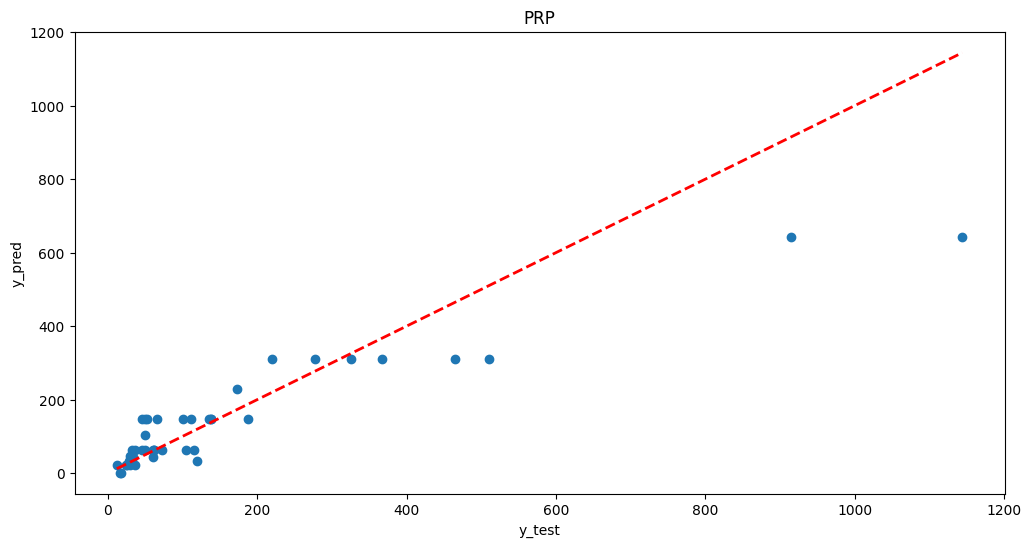

In [62]:
# 맴버 features 선택
num_features = ['MMAX', 'MMIN', 'CACH', 'CHMIN','CHMAX','ERP']

X = cpu[num_features] # 2차원 배열
y = cpu['PRP'] # 1차원 시리즈

#데이터 분리
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size = 0.2, random_state= 21)

# 전처리 파이프라인 설정
num_tranformer = Pipeline(steps=[
    ('scaler',StandardScaler()),
])

preprocessor = ColumnTransformer(transformers=[
    ('num',num_tranformer, num_features),
])

# 개별 모델 정의
models = [('lr', LinearRegression()), ('sgd',SGDRegressor()),]

# 앙상블 모델 정의
ensemble = VotingRegressor(estimators= models)

# 모델 파이프라인 생성
model_pipline = Pipeline(steps=[
    ('preprocessor',preprocessor), 
    ('ensemble',ensemble),
])

# 하이퍼파라미터 튜닝
params_grid = {
    "ensemble__sgd__alpha" : [ 0.0001, 0.1, 1.0]  ,
    "ensemble__sgd__max_iter" : [1000, 2000, 3000],
}

# GridSearchCV 설정 및 모델 학습
grid_search = GridSearchCV(model_pipline,params_grid, cv = 5, scoring='neg_mean_squared_error' , return_train_score=True )
# grid_search_mae = GridSearchCV(model_pipline,params_grid, cv = 5, scoring='neg_mean_absolute_error' , return_train_score=True )
# grid_search_r2 = GridSearchCV(model_pipline,params_grid, cv = 5, scoring='r2' , return_train_score=True )

grid_search.fit(X_train2, y_train2)

# 최적 파라미터 출력
print(f" Best parameters : {grid_search.best_params_}")

# 최적 모델로 예측
best_model4 = grid_search.best_estimator_

y_pred3 = best_model4.predict(X_test2)
y_pred4 = best_model4.predict(X_train2)

y_pred3 = best_model4.predict(X_test2)
mse3 = mean_squared_error(y_test2, y_pred3)
mae3 = mean_absolute_error(y_test2, y_pred3)
r23 = r2_score(y_test2, y_pred3)

y_pred4 = best_model4.predict(X_train2)
mse4 = mean_squared_error(y_train2, y_pred4)
mae4 = mean_absolute_error(y_train2, y_pred4)
r24 = r2_score(y_train2, y_pred4)

print(f"MSE: {mse3}, MAE:{mae3}, R^2:{r23}")

plt.figure(figsize=(12,6))
plt.scatter(y_test, y_pred1)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.title("PRP")

(4) I. 3차 프로그래밍 과제의 기본모델의 (2) 단계와 II. 4차 프로그래밍 과제의 제안 모델의 (2) 단계에서 얻은 학습 데이터와 테스트 데이터에 대한 성능 지표(MSE, MAE, R^2, 교차 검증)를 데이터프레임에 저장하여 이 성능 결과를 바 차트로 시각화하여 학습 데이터와 테스트 데이터에 대한 각 모델의 성능 차이를 비교 분석하시오.

              Model   Data          MSE        MAE       R^2
0  LinearRegression   Test  4356.721470  35.490803  0.916794
1  LinearRegression  Train  1442.617766  22.564151  0.920967
2    Best_estimator   Test  3923.258562  34.307844  0.925072
3    Best_estimator  Train  1447.365287  22.380040  0.920707


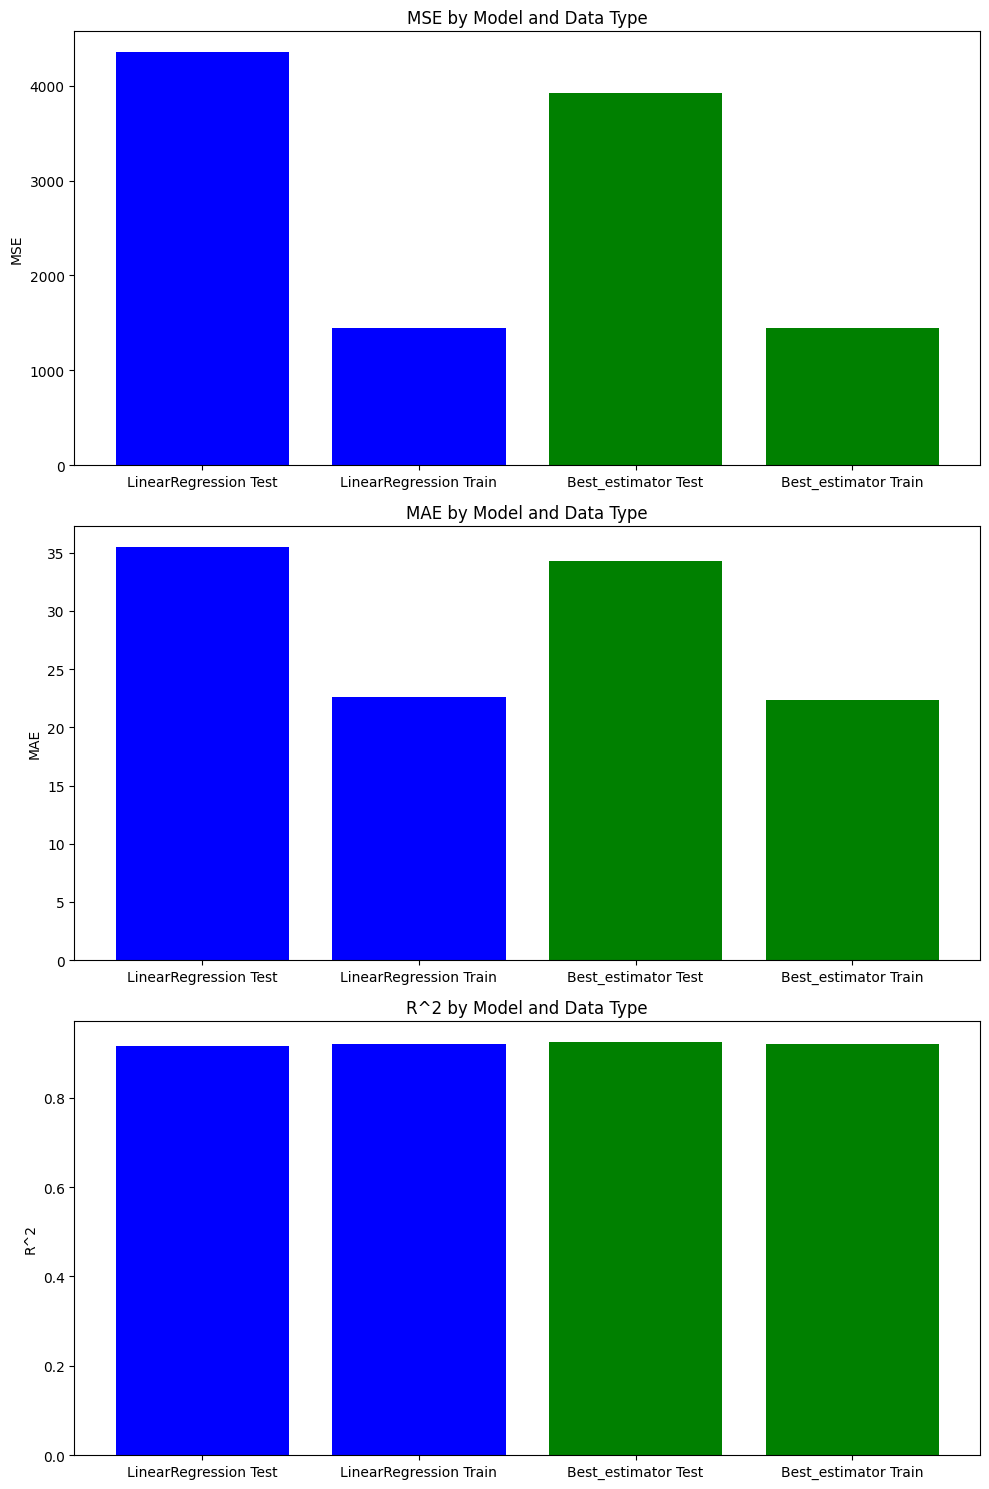

In [118]:
data = pd.read_csv("data.csv")

performance_data = {
    "Model": ["Best_estimator","Best_estimator"],
    "Data": ["Test","Train"],
    "MSE": [mse3,mse4],
    "MAE": [mae3,mae4],
    "R^2": [r23,r24],
}

df = pd.DataFrame(performance_data)
result = pd.concat([data, df], axis=0, ignore_index=True)
print(result)

# 막대 그래프 시각화
fig, ax = plt.subplots(3, 1, figsize=(10, 15))

# MSE 막대 그래프
ax[0].bar(result['Model'] + ' ' + result['Data'], result['MSE'], color=['blue', 'blue', 'green', 'green'])
ax[0].set_title('MSE by Model and Data Type')
ax[0].set_ylabel('MSE')

# MAE 막대 그래프
ax[1].bar(result['Model'] + ' ' + result['Data'], result['MAE'], color=['blue', 'blue', 'green', 'green'])
ax[1].set_title('MAE by Model and Data Type')
ax[1].set_ylabel('MAE')

# R^2 막대 그래프
ax[2].bar(result['Model'] + ' ' + result['Data'], result['R^2'], color=['blue', 'blue', 'green', 'green'])
ax[2].set_title('R^2 by Model and Data Type')
ax[2].set_ylabel('R^2')

plt.tight_layout()
plt.show()